In [1]:
import sys
import warnings
from copy import deepcopy
sys.path.insert(0, "..")
warnings.filterwarnings("ignore")

import numpy as np
import tensorflow as tf

from osvgp.datasets import load_snelson
from osvgp.kernels import SquaredExponential
from osvgp.metrics import compute_lpd, compute_rmse
from osvgp.metrics import compute_kl_from_exact_posterior
from osvgp.models import SGPR, OSGPR
from osvgp.optimisers import LBFGS
from osvgp.plotting import plot_dataset, plot_predictions
from osvgp.plotting import plot_metrics_2d, plot_metrics_3d
from osvgp.processing import train_test_split

In [2]:
# Fix random states
tf.random.set_seed(69)
rng = np.random.RandomState(69)

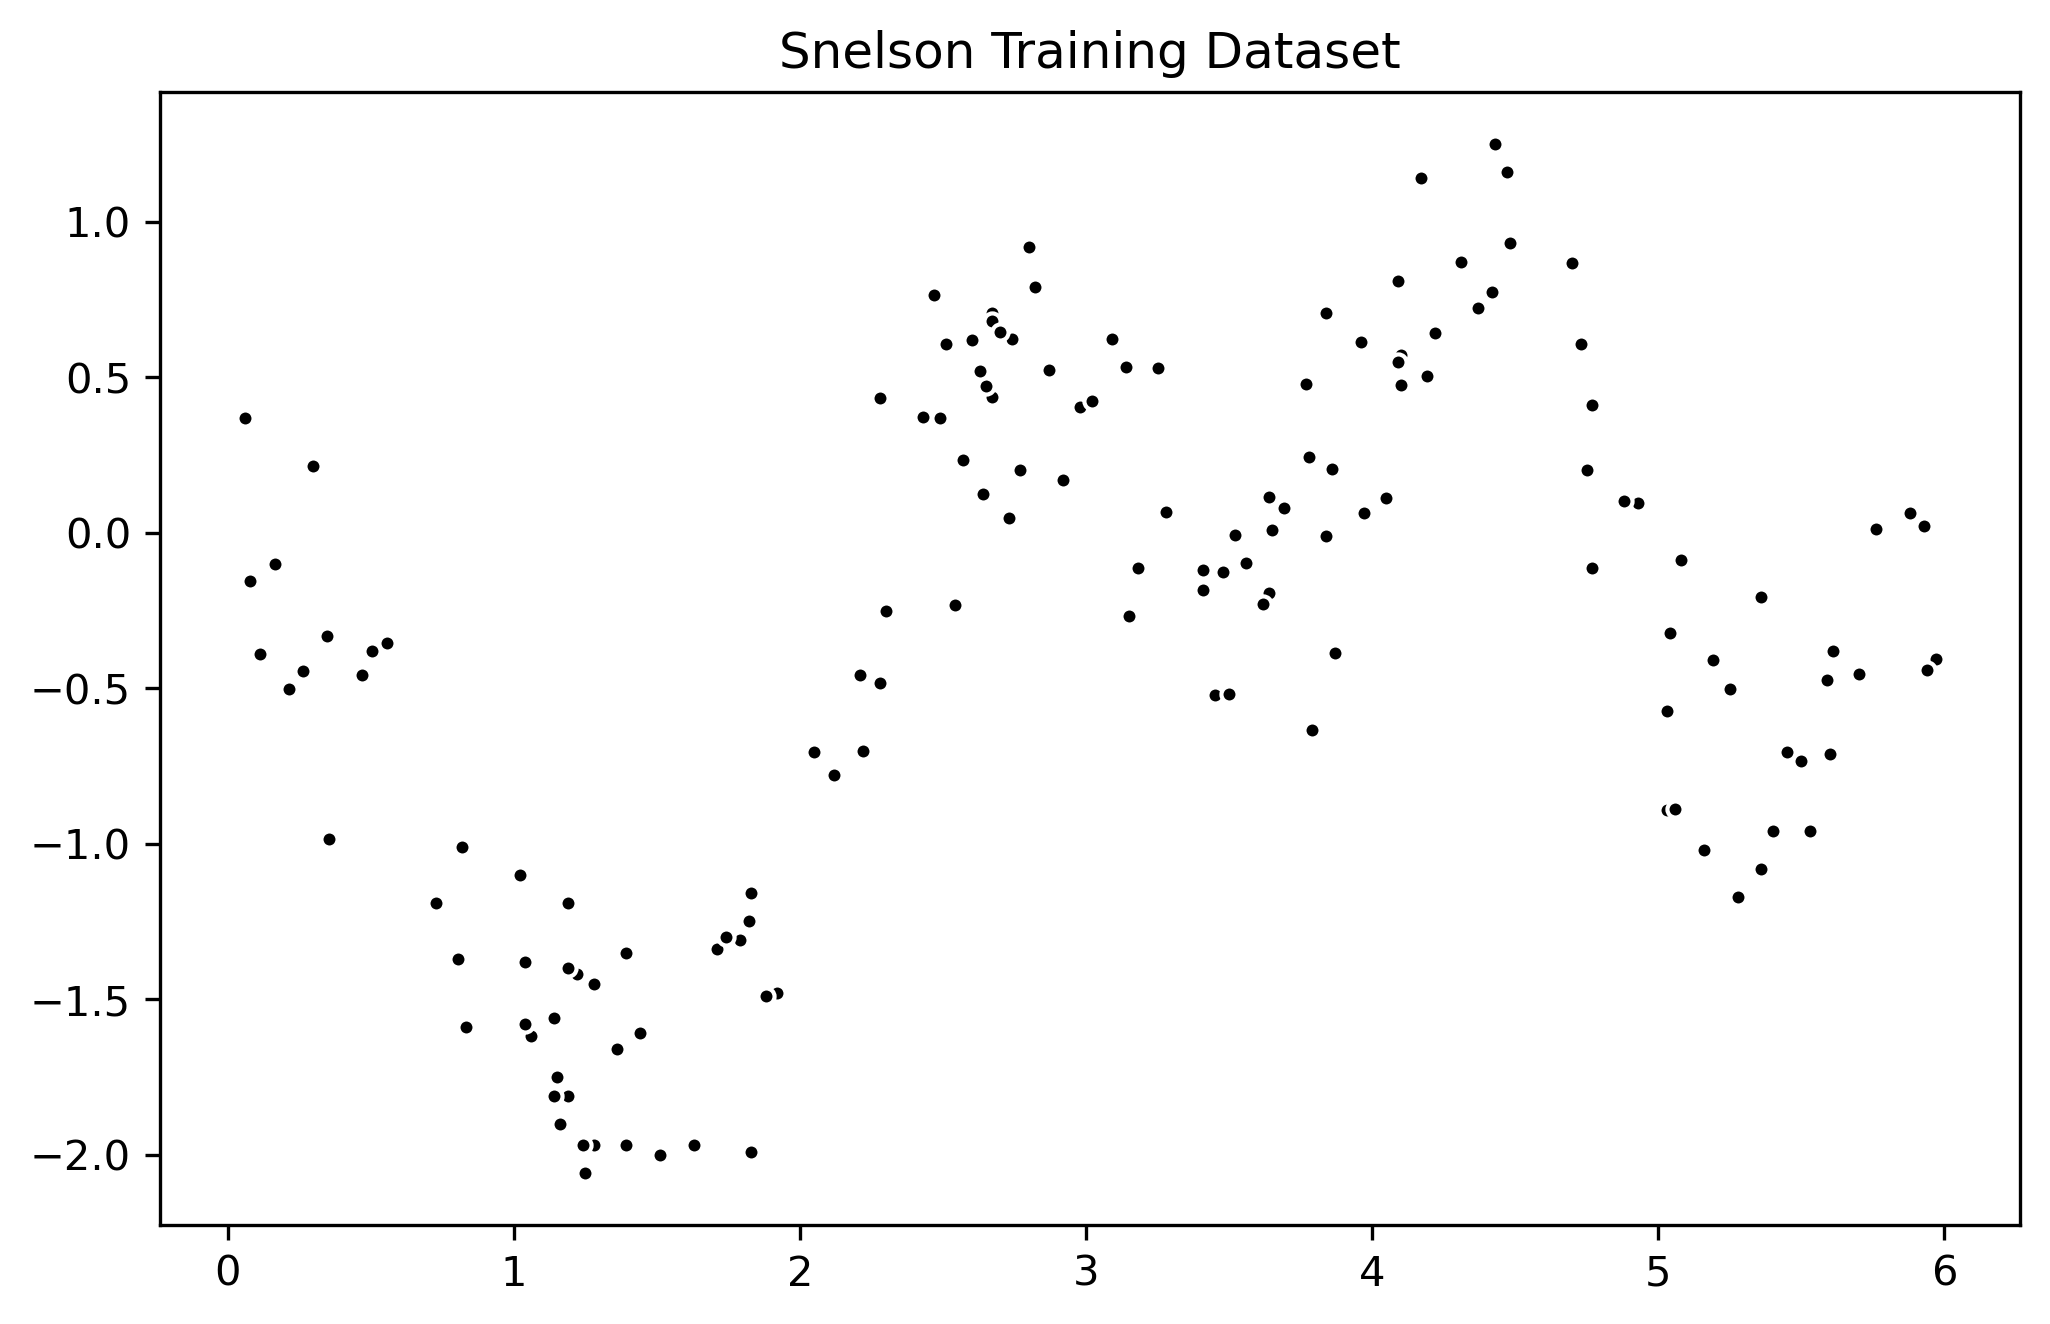

In [3]:
# Load Snelson dataset
data = load_snelson()
train_data, test_data = train_test_split(data, test_size=0.25)
X_train, y_train = train_data

# Plot dataset
plot_dataset(train_data, title="Snelson Training Dataset")

2022-08-05 12:41:16.990357: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-08-05 12:41:17.672422: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


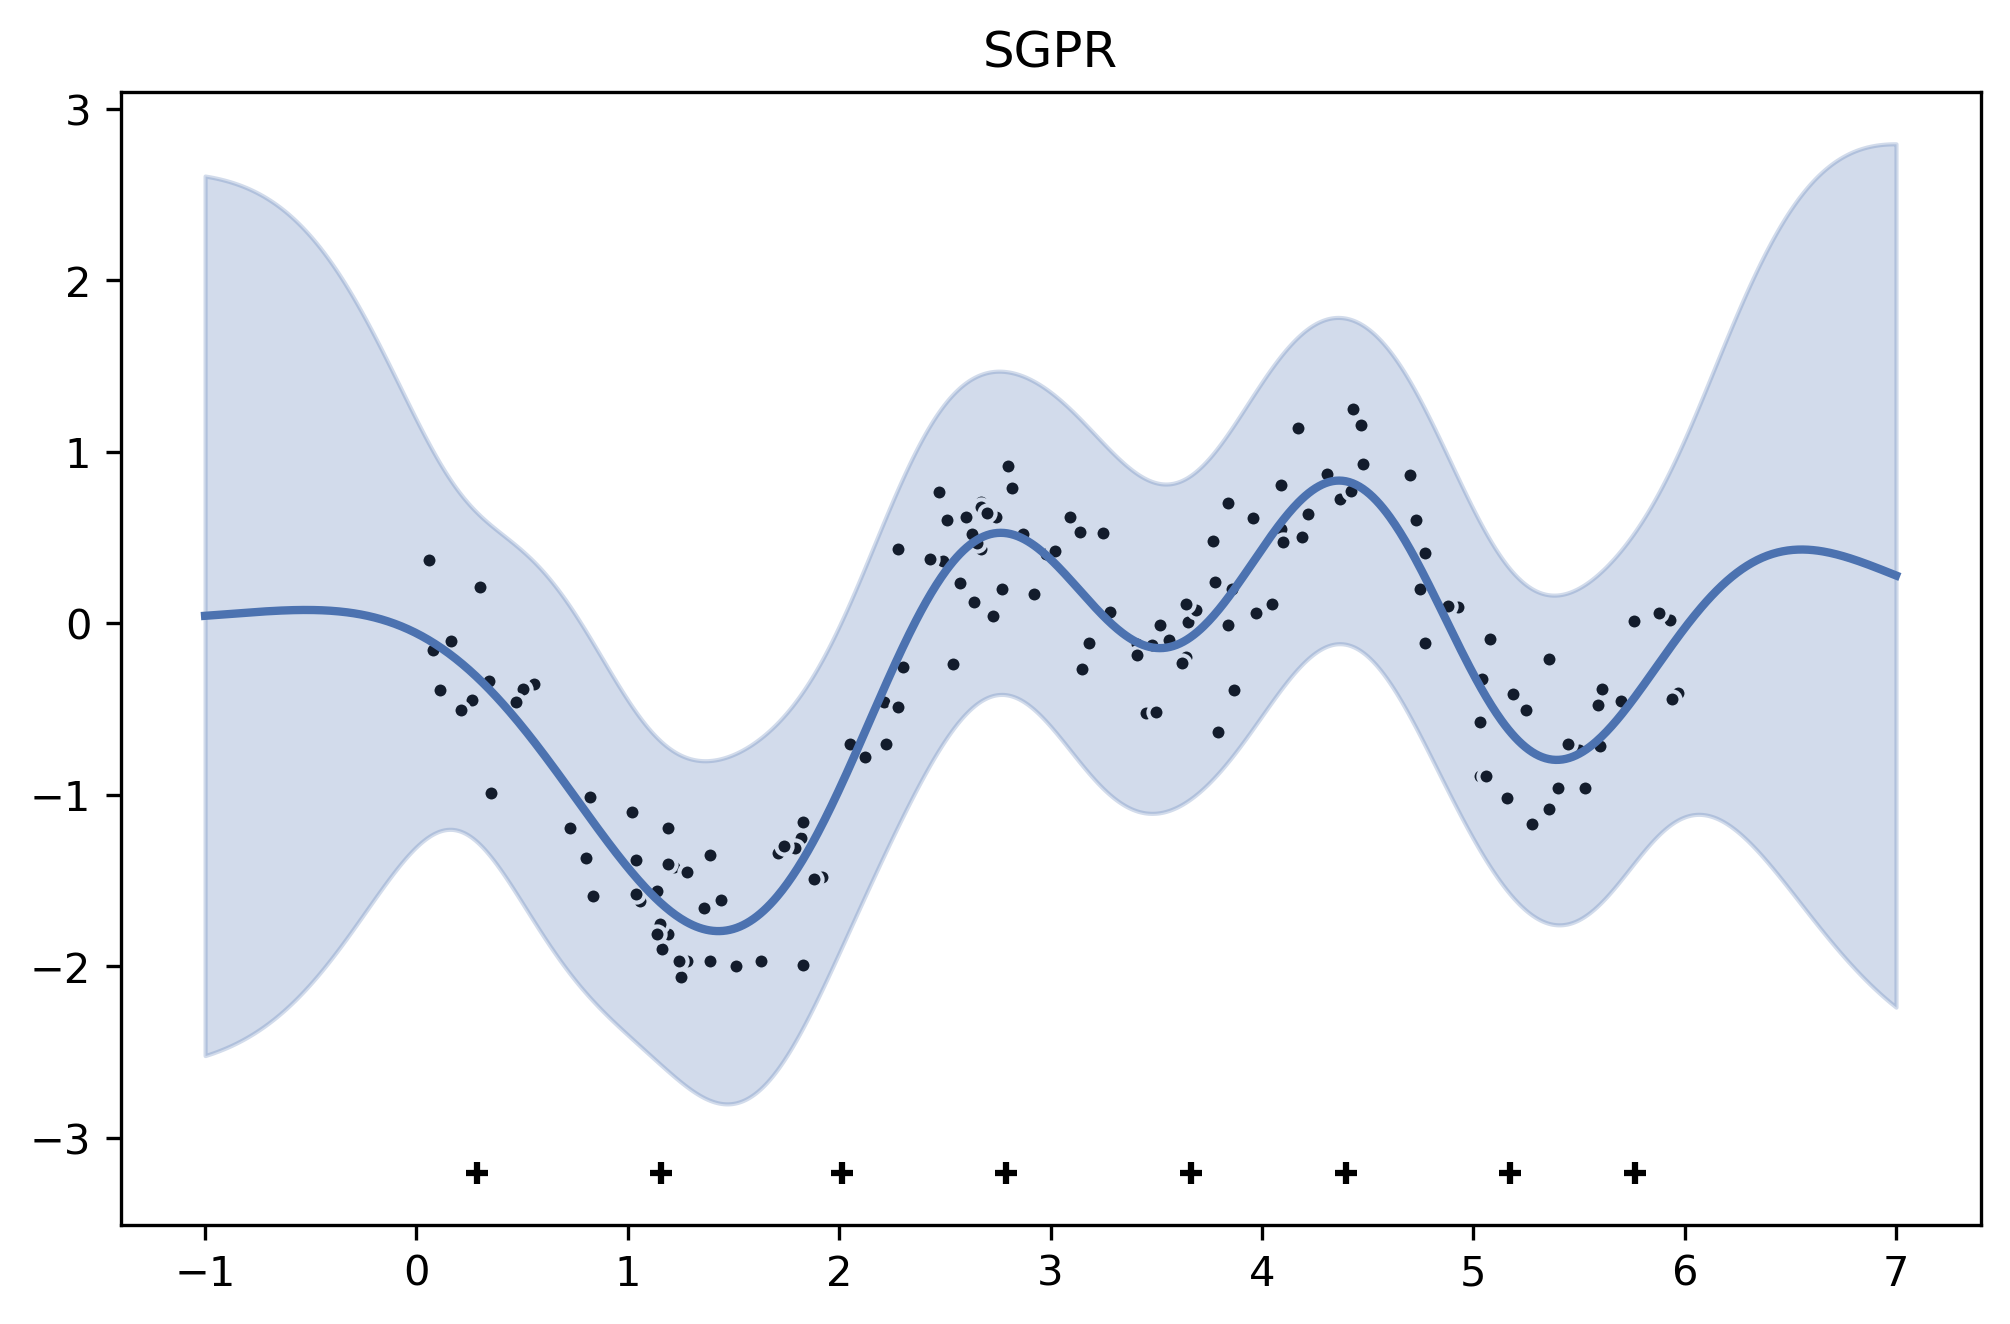

In [4]:
M = 8
kernel = SquaredExponential()
iv = X_train[:M].copy()
sgpr = SGPR(train_data, kernel, iv)
optimiser = LBFGS()
optimiser.minimise(sgpr.training_loss, sgpr.trainable_variables)
Xnew = np.linspace(-1.0, 7.0, 1000).reshape(-1, 1)
sgpr_mean, sgpr_var = sgpr.predict_y(Xnew)
sgpr_preds = (Xnew, sgpr_mean, sgpr_var)
sgpr_iv = sgpr.Z
plot_predictions(train_data, sgpr_preds, sgpr_iv, c="C0", title="SGPR")

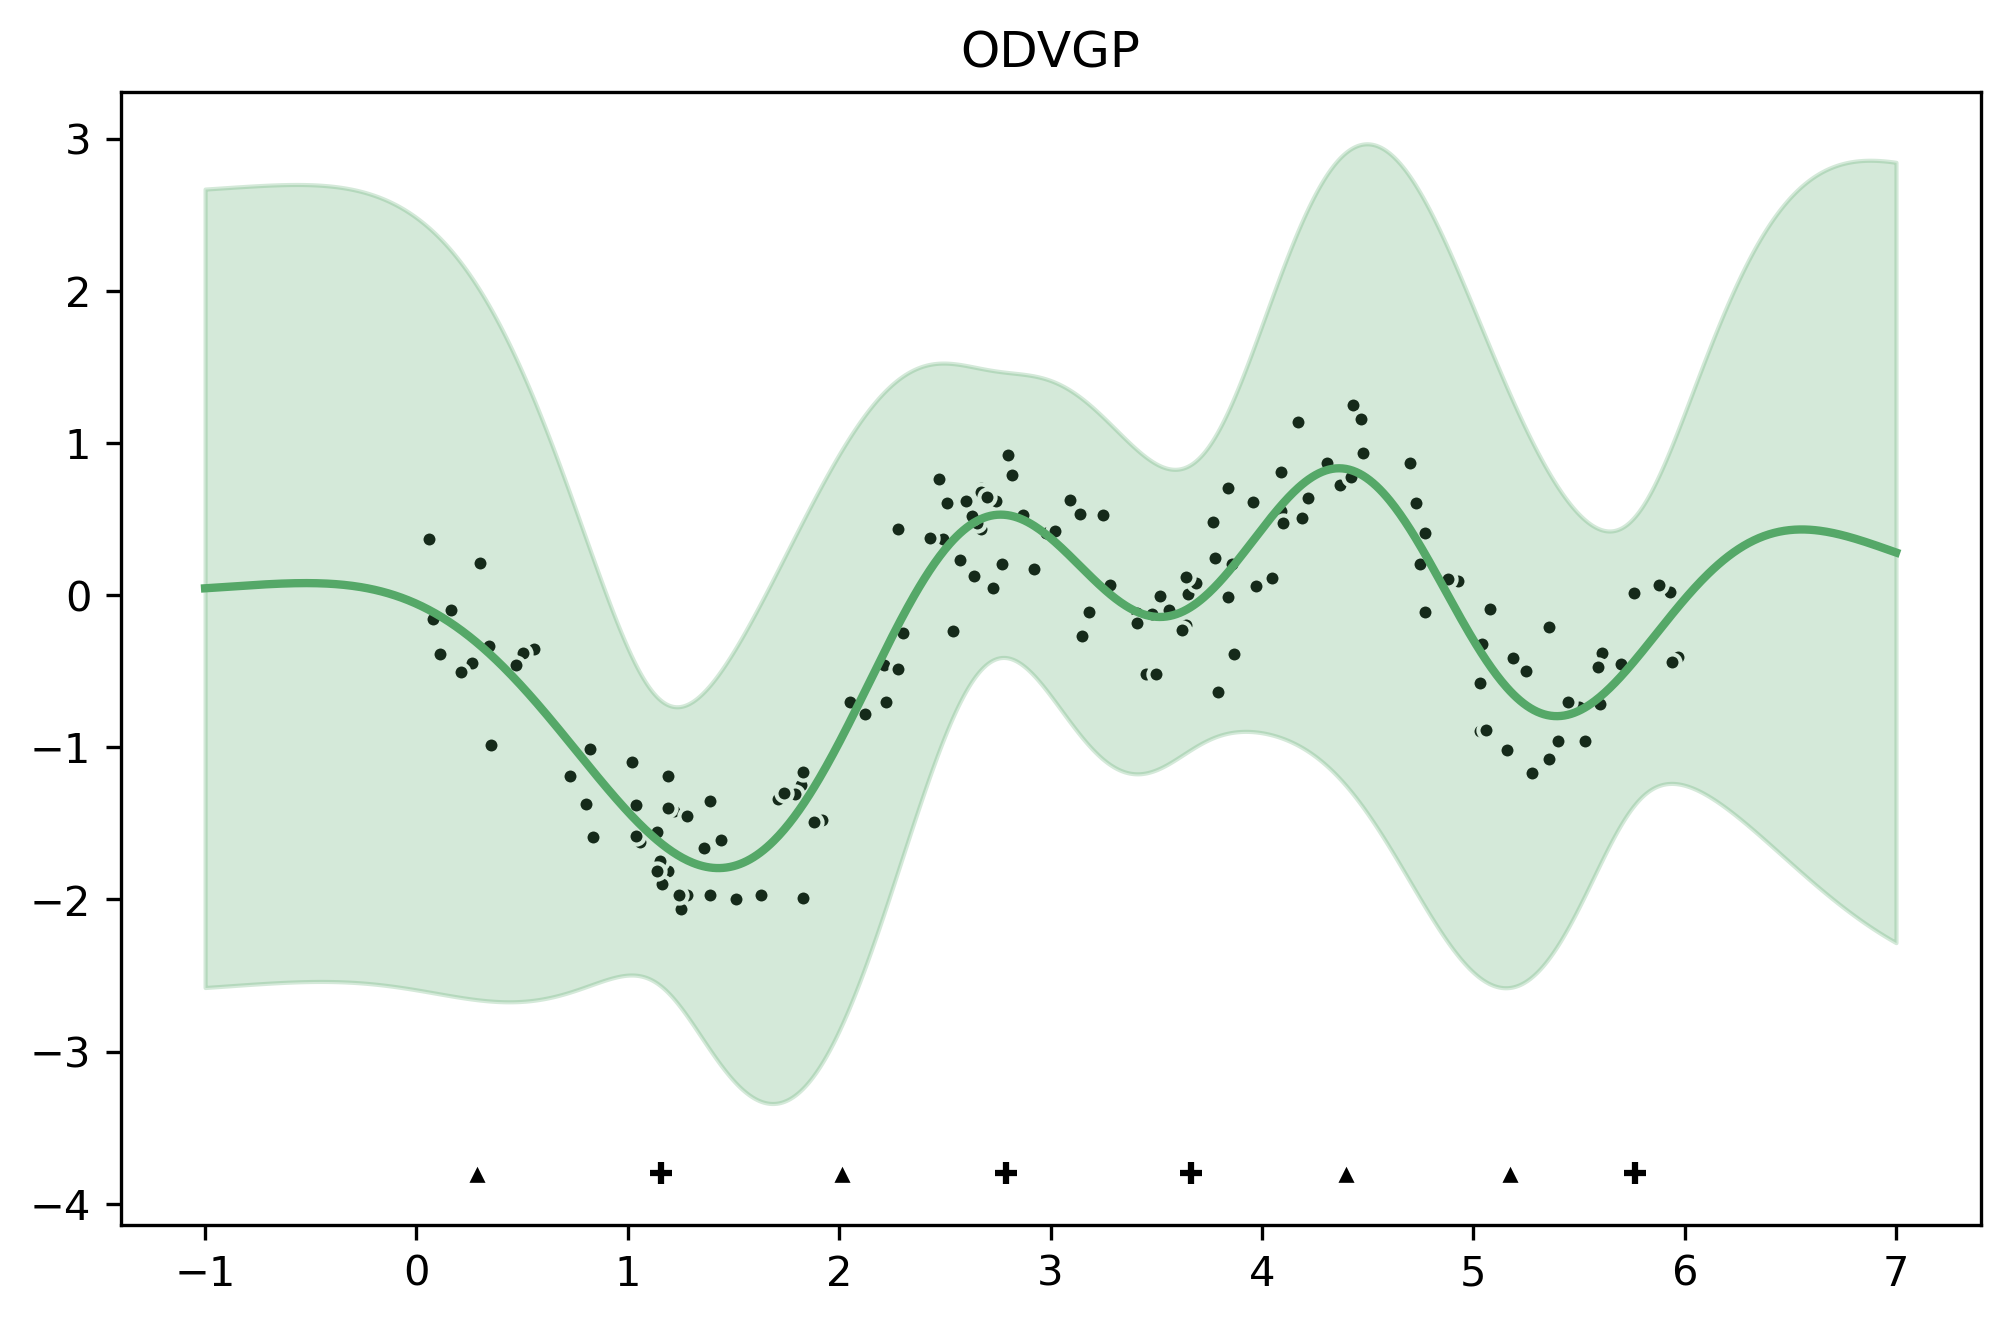

In [5]:
Mu, Mv = 4, 4
kernel = SquaredExponential()
iv = (X_train[:Mu].copy(), X_train[Mu:Mu+Mv].copy())
odvgp = OSGPR(train_data, kernel, iv, method="ODVGP")
optimiser = LBFGS()
optimiser.minimise(odvgp.training_loss, odvgp.trainable_variables)
Xnew = np.linspace(-1.0, 7.0, 1000).reshape(-1, 1)
odvgp_mean, odvgp_var = odvgp.predict_y(Xnew)
odvgp_preds = (Xnew, odvgp_mean, odvgp_var)
odvgp_iv = (odvgp.Z, odvgp.O)
plot_predictions(train_data, odvgp_preds, odvgp_iv, c="C1", title="ODVGP")

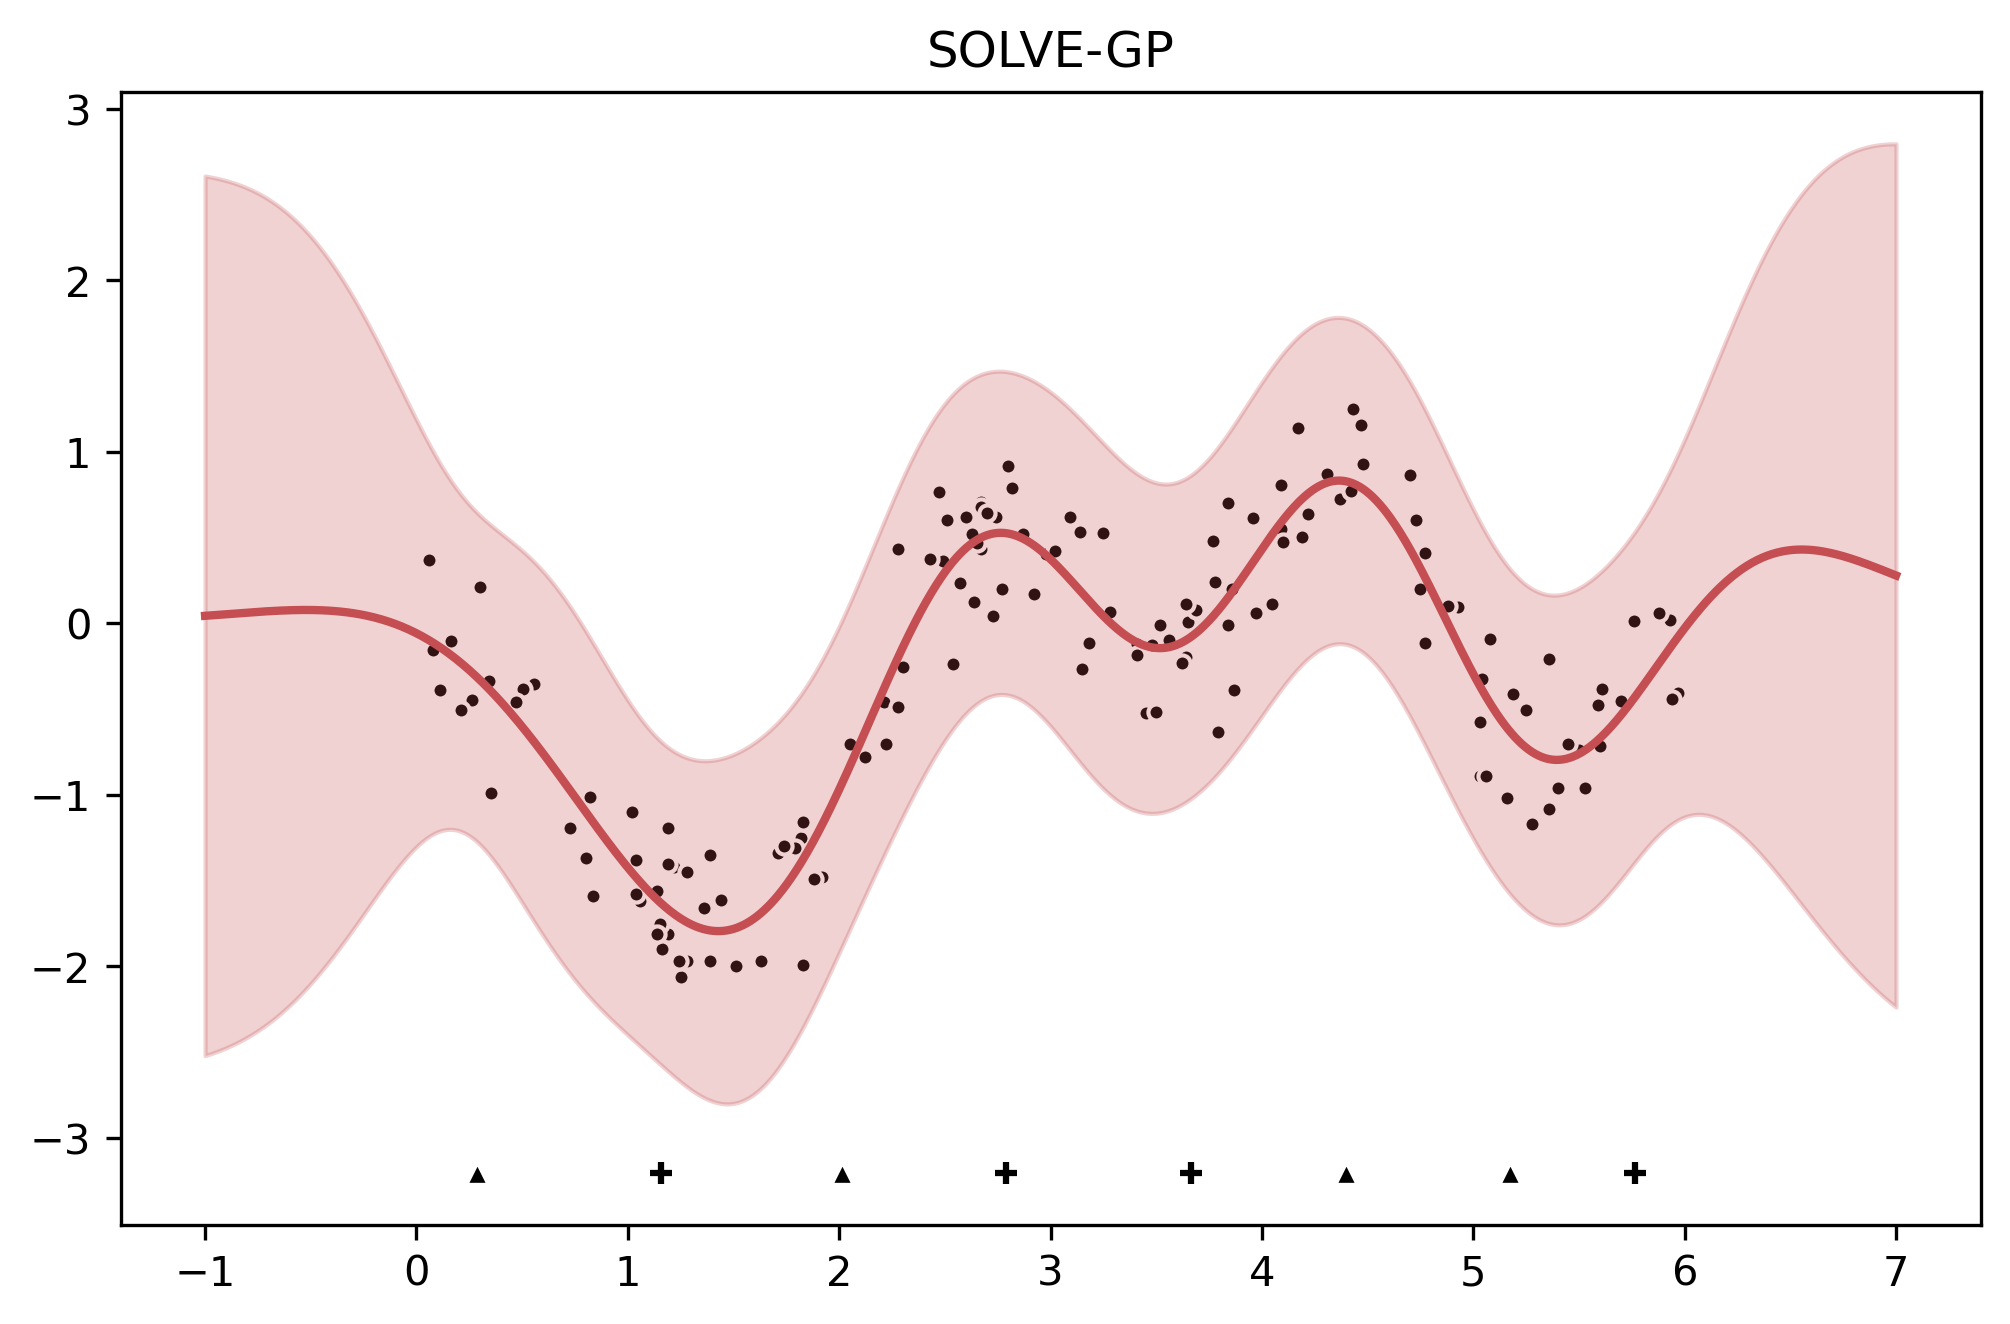

In [6]:
Mu, Mv = 4, 4
kernel = SquaredExponential()
iv = (X_train[:Mu].copy(), X_train[Mu:Mu+Mv].copy())
solvegp = OSGPR(train_data, kernel, iv, method="SOLVE-GP")
optimiser = LBFGS()
optimiser.minimise(solvegp.training_loss, solvegp.trainable_variables)
Xnew = np.linspace(-1.0, 7.0, 1000).reshape(-1, 1)
solvegp_mean, solvegp_var = solvegp.predict_y(Xnew)
solvegp_preds = (Xnew, solvegp_mean, solvegp_var)
solvegp_iv = (solvegp.Z, solvegp.O)
plot_predictions(train_data, solvegp_preds, solvegp_iv, c="C2", title="SOLVE-GP")

In [13]:
M_range = range(2, 151, 2)
base_dict = {"SVGP": [], "ODVGP": [], "SOLVE-GP": []}
lpds, rmses, kls = deepcopy(base_dict), deepcopy(base_dict), deepcopy(base_dict)

for M in M_range:

    # Initialise models
    kernel = SquaredExponential()
    iv_reg = X_train[:M].copy()
    iv_orthog = (X_train[:M//2].copy(), X_train[M//2:M].copy())
    svgp = SGPR(train_data, deepcopy(kernel), iv_reg)
    odvgp = OSGPR(train_data, deepcopy(kernel), iv_orthog, method="ODVGP")
    solvegp = OSGPR(train_data, deepcopy(kernel), iv_orthog, method="SOLVE-GP")

    # # Optimise models
    # for model in [svgp, odvgp, solvegp]:
    #     optimiser = LBFGS()
    #     optimiser.minimise(model.training_loss, model.trainable_variables)
    
    # Compute metrics
    for model, key in zip([svgp, odvgp, solvegp], base_dict.keys()):
        lpds[key].append(compute_lpd(model, test_data))
        rmses[key].append(compute_rmse(model, test_data))
        kls[key].append(compute_kl_from_exact_posterior(model))

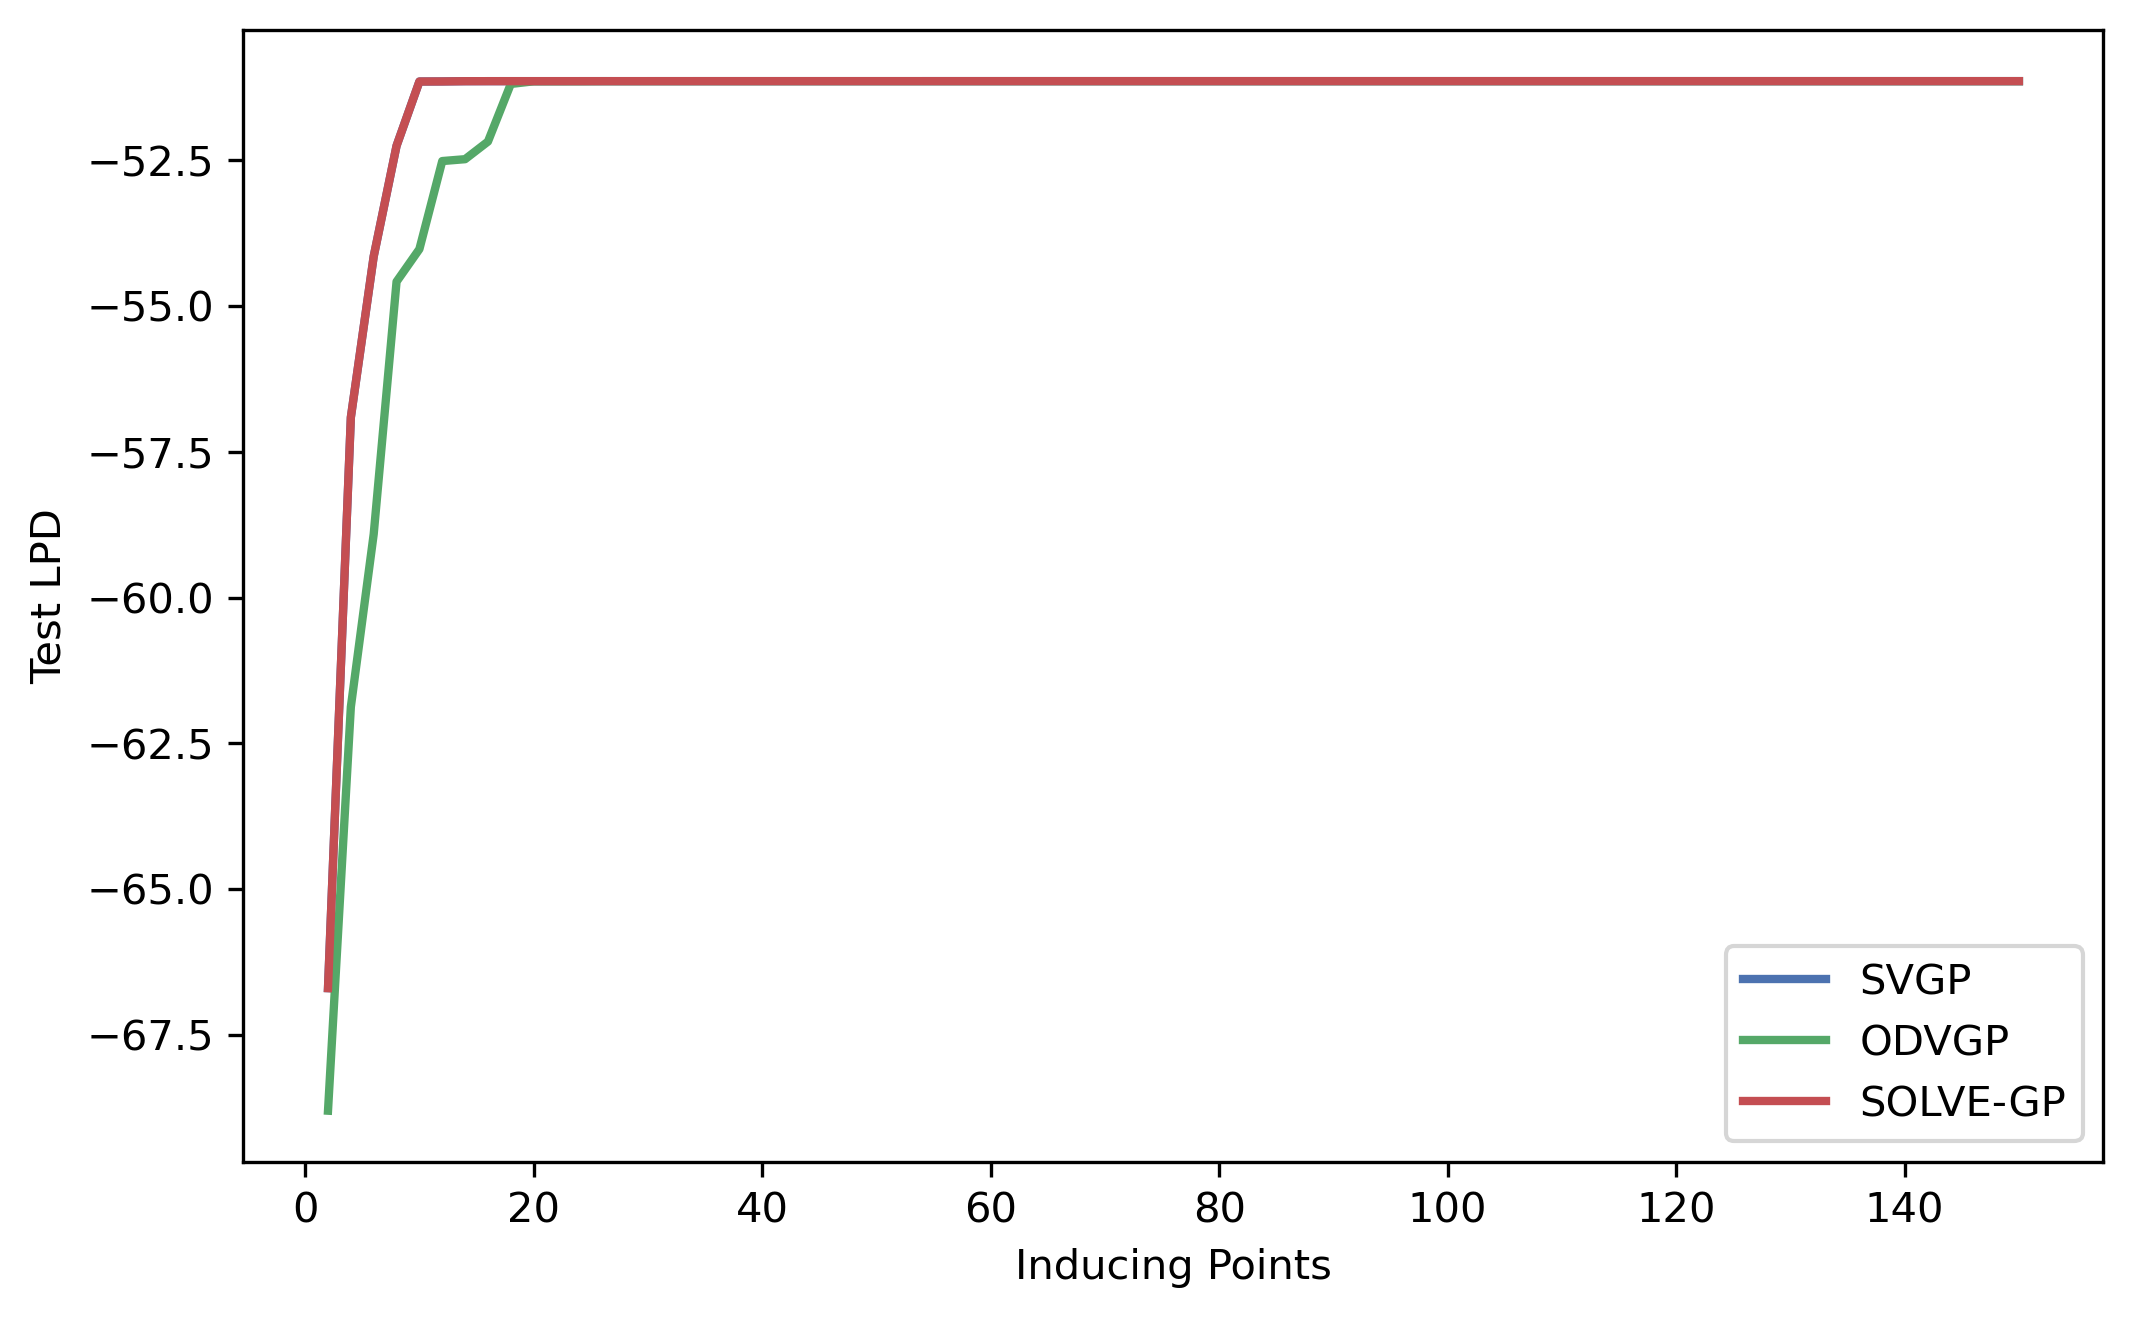

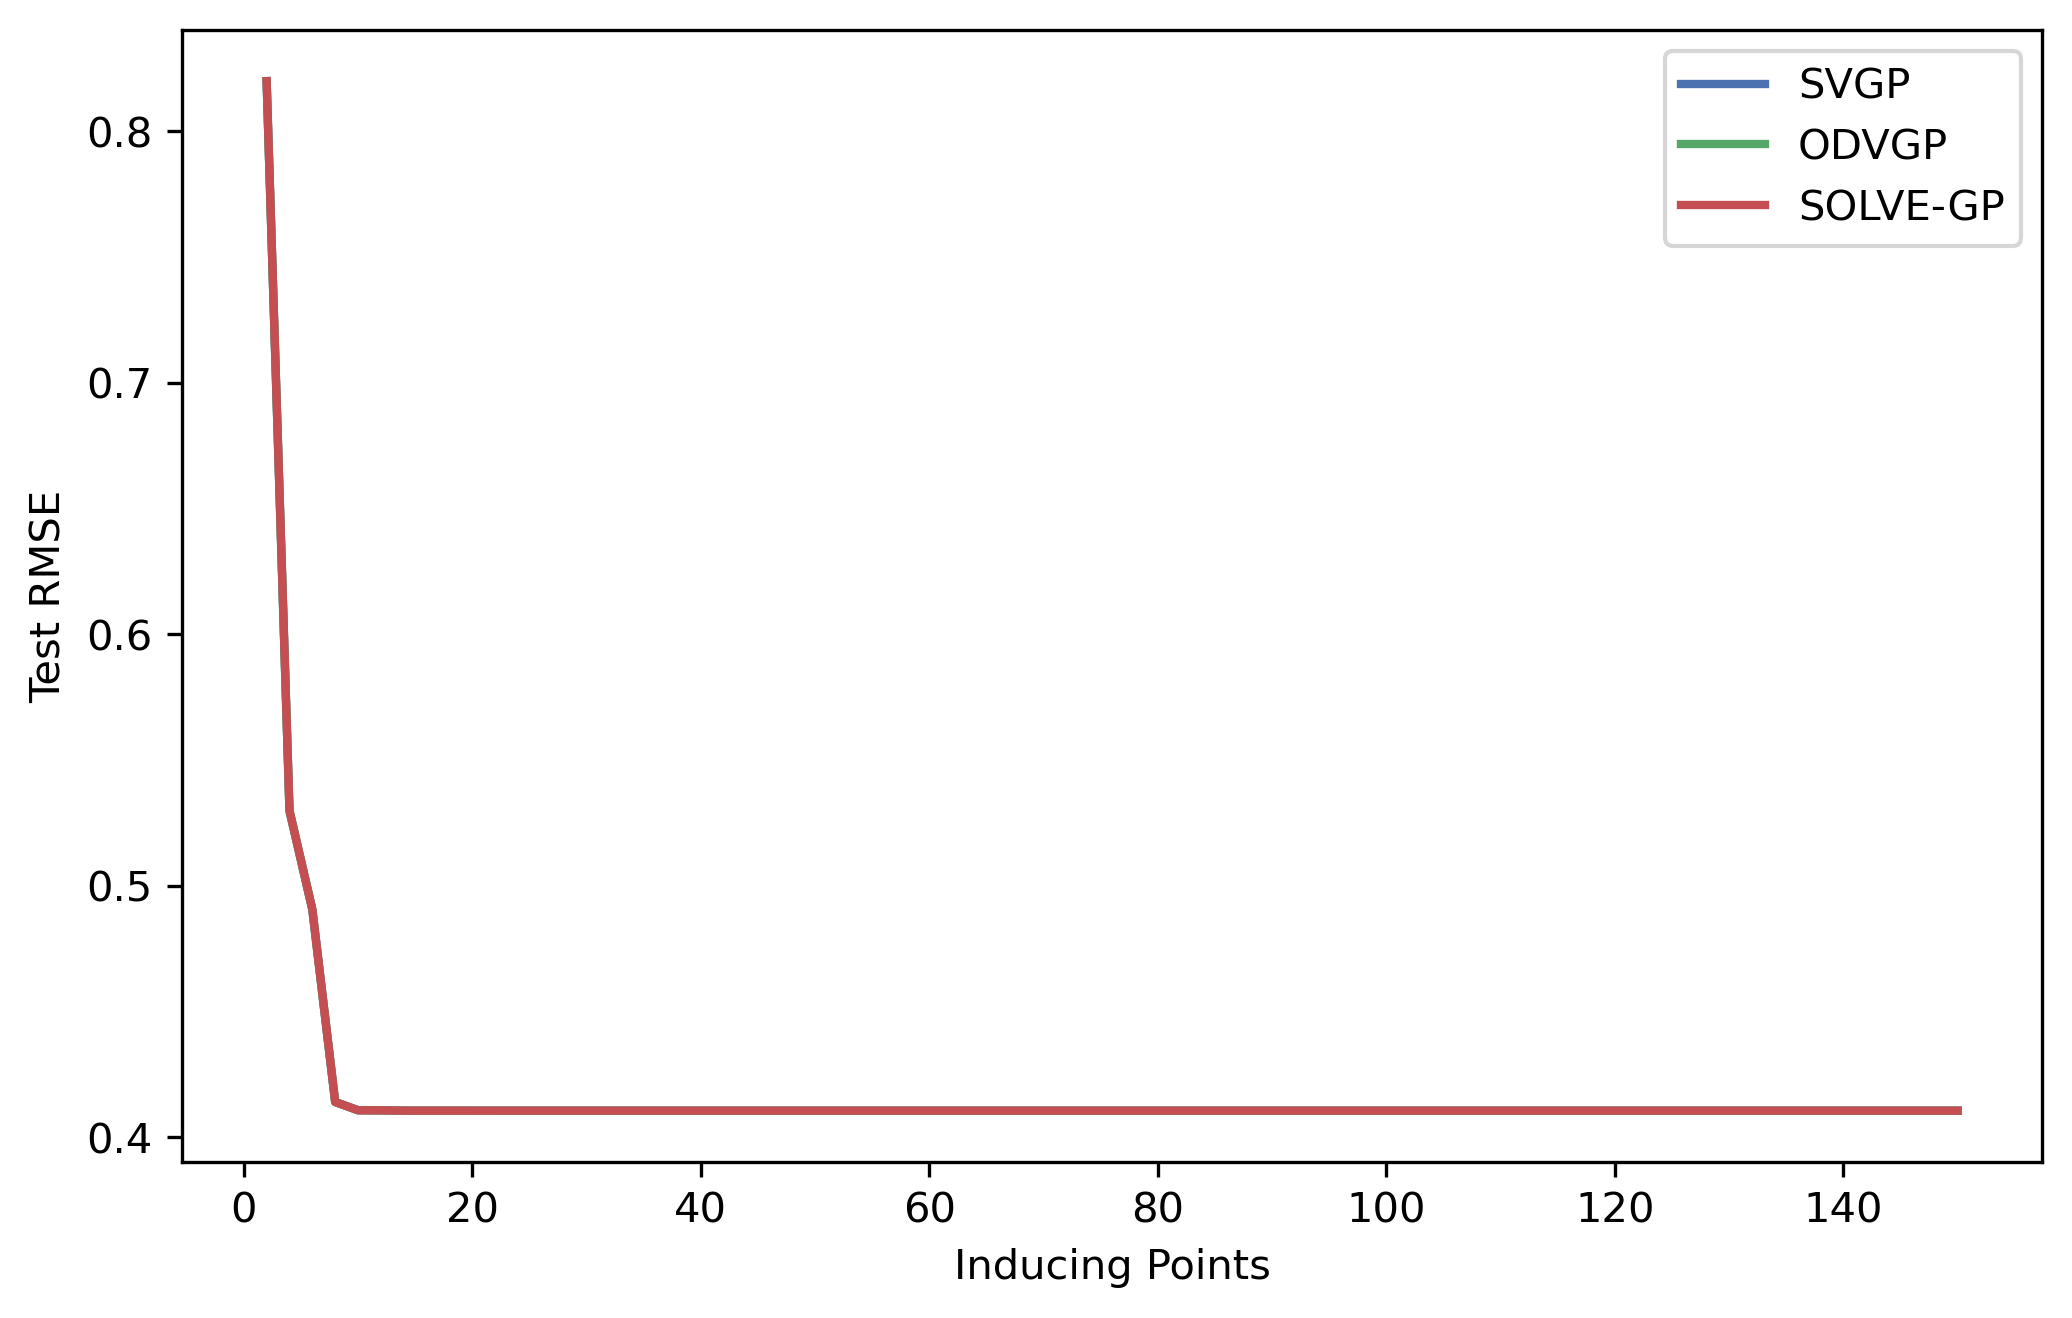

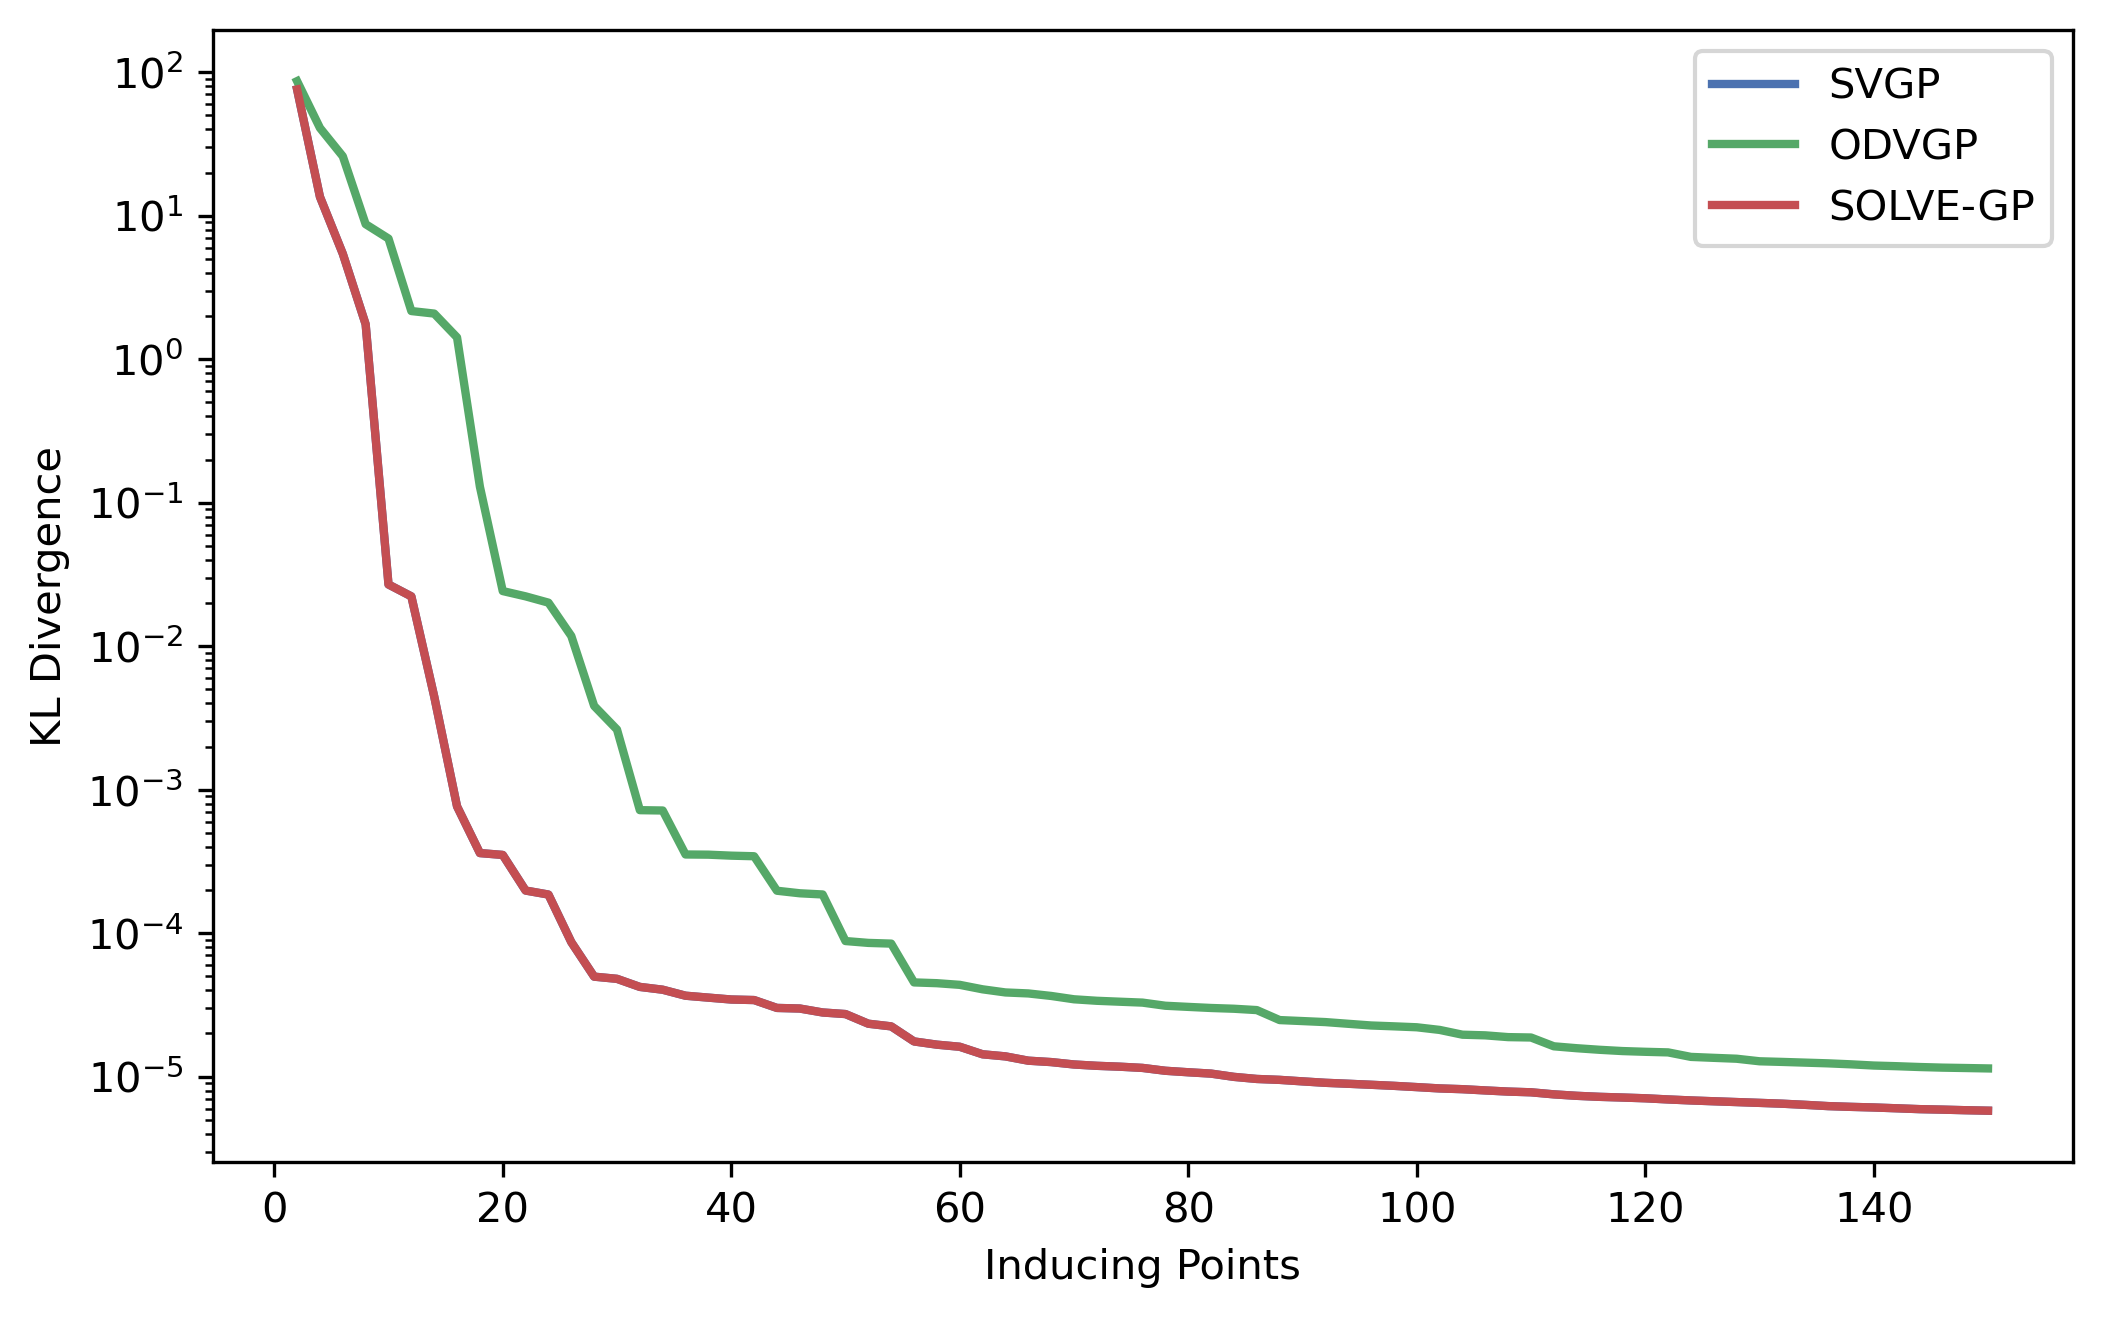

In [14]:
# LPD plot
plot_metrics_2d(M_range, 
                lpds,
                colours=["C0", "C1", "C2"],
                xlabel="Inducing Points",
                ylabel="Test LPD",
                yscale="linear",
                legend=True)

# RMSE plot
plot_metrics_2d(M_range, 
                rmses,
                colours=["C0", "C1", "C2"],
                xlabel="Inducing Points",
                ylabel="Test RMSE",
                yscale="linear",
                legend=True)

# KL divergence plot
plot_metrics_2d(M_range, 
                kls,
                colours=["C0", "C1", "C2"],
                xlabel="Inducing Points",
                ylabel="KL Divergence",
                yscale="log",
                legend=True)

In [61]:
M_range = range(1, 21, 1)
zeros = np.zeros((len(M_range), len(M_range)))
base_dict = {"ODVGP": deepcopy(zeros), "SOLVE-GP": deepcopy(zeros)}
lpds, rmses, kls = deepcopy(base_dict), deepcopy(base_dict), deepcopy(base_dict)

for i, Mu in enumerate(M_range):
    for j, Mv in enumerate(M_range):

        # Initialise models
        kernel = SquaredExponential()
        iv_orthog = (X_train[:Mu].copy(), X_train[Mu:Mu+Mv].copy())
        odvgp = OSGPR(train_data, deepcopy(kernel), iv_orthog, method="ODVGP")
        solvegp = OSGPR(train_data, deepcopy(kernel), iv_orthog)
        
        # Optimise models
        for model in [odvgp, solvegp]:
            optimiser = LBFGS()
            optimiser.minimise(model.training_loss, model.trainable_variables)

        # Compute metrics
        for model, key in zip([odvgp, solvegp], base_dict.keys()):
            lpds[key][i][j] = compute_lpd(model, test_data)
            rmses[key][i][j] = compute_rmse(model, test_data)
            kls[key][i][j] = compute_kl_from_exact_posterior(model)

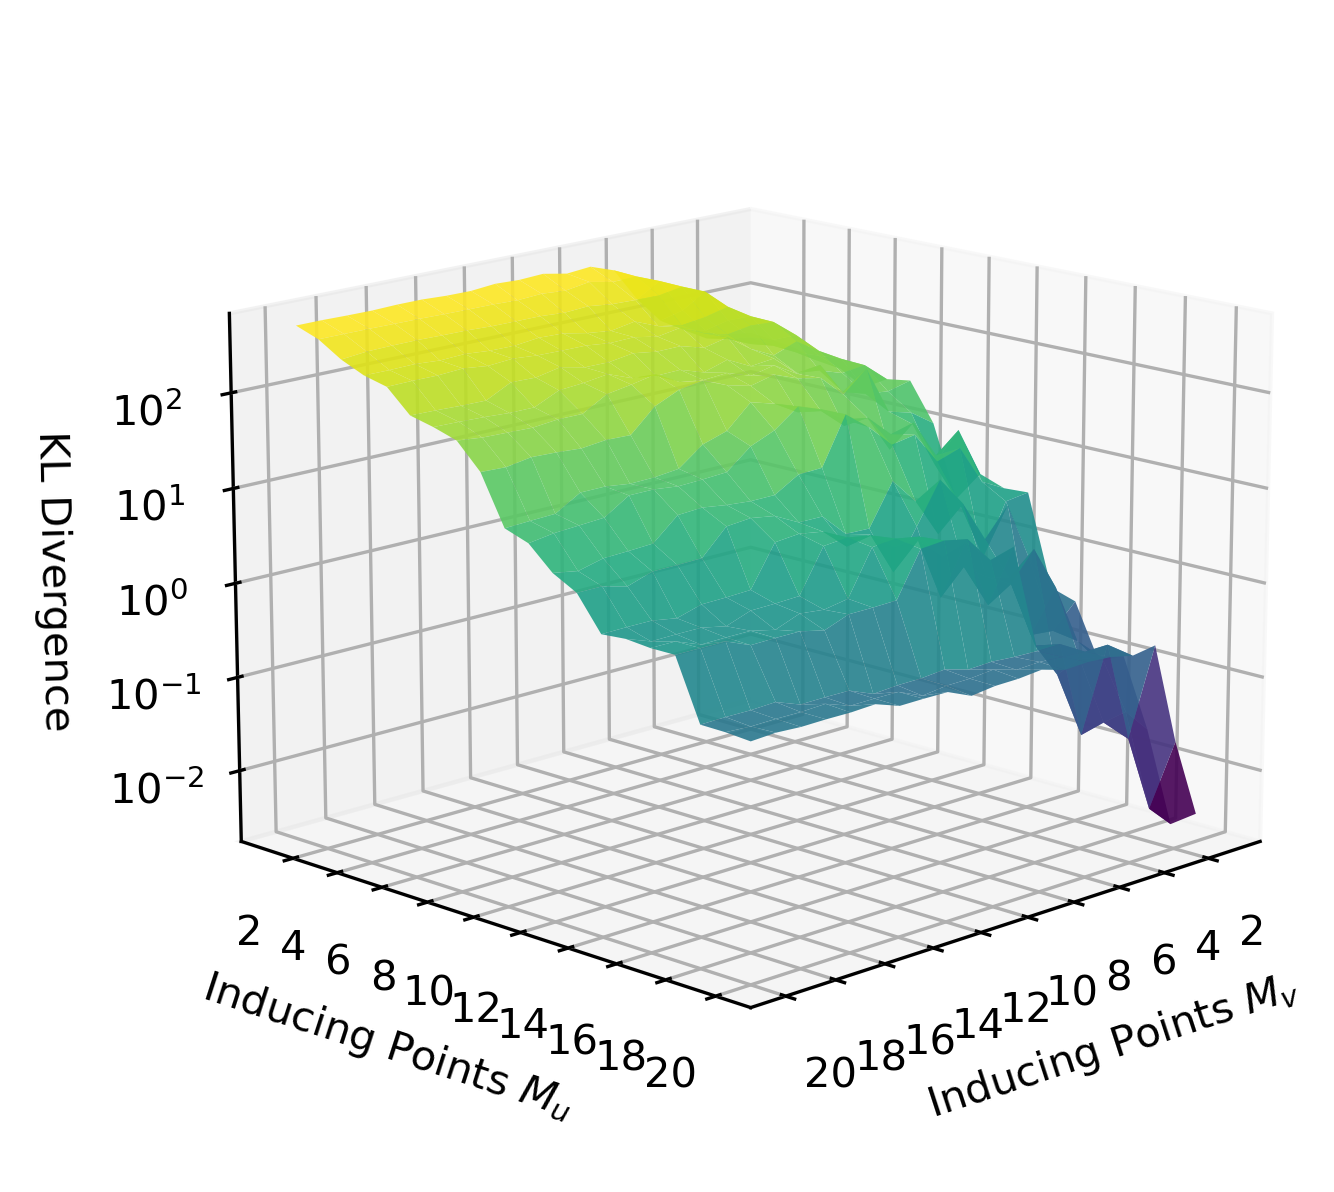

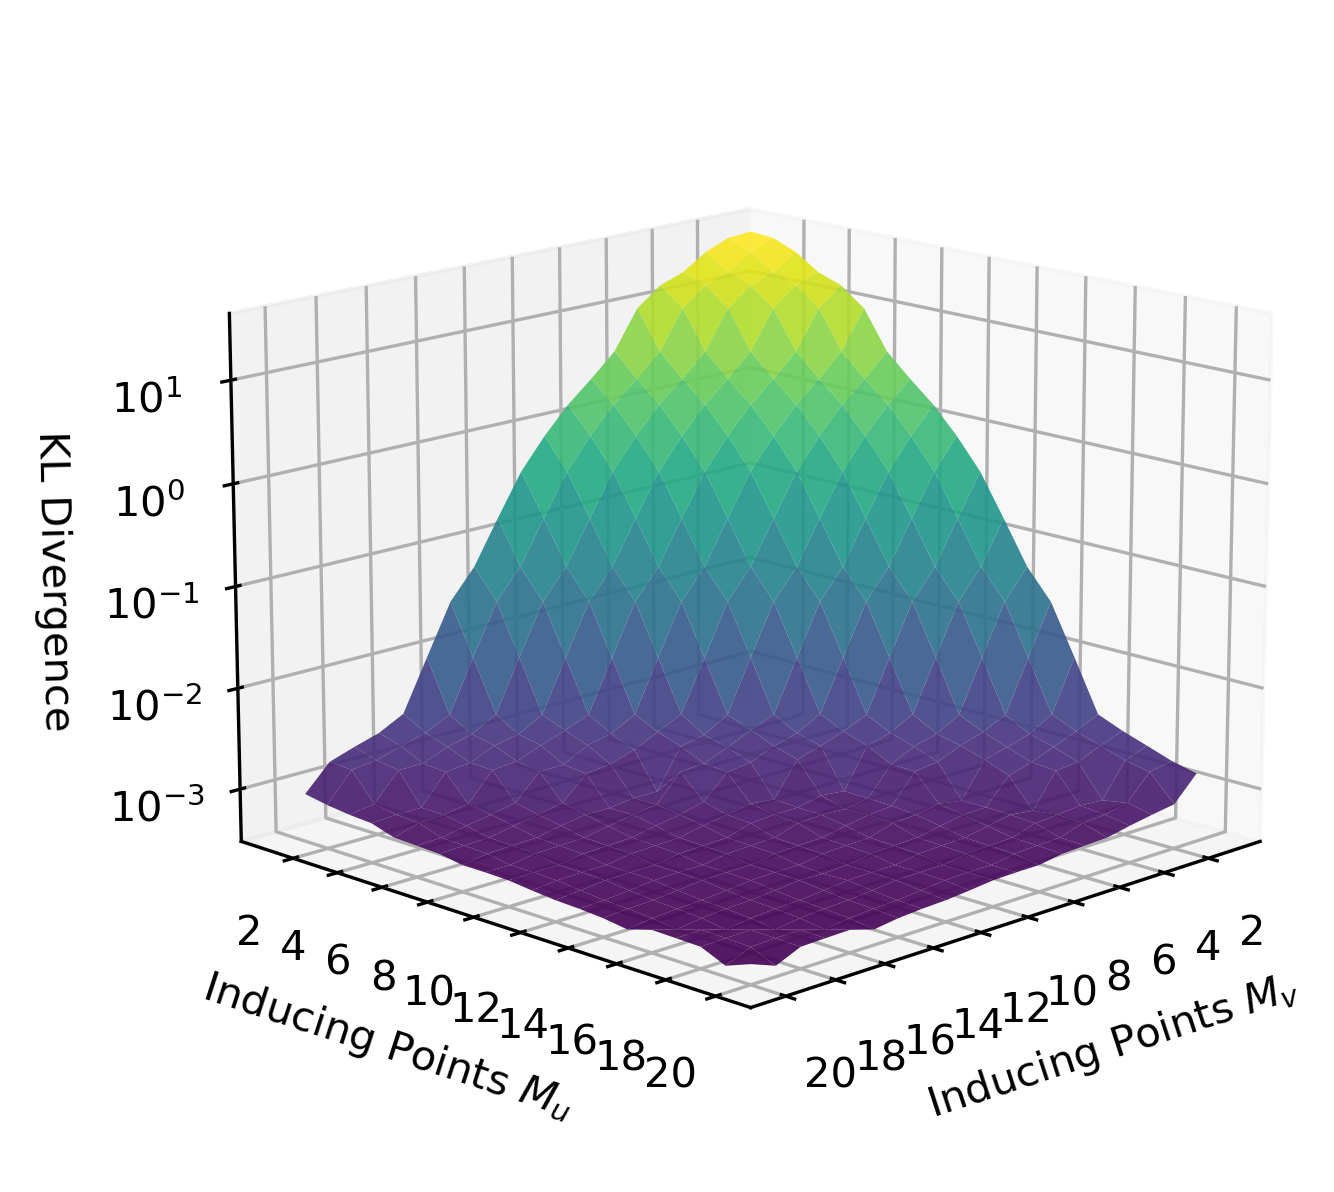

In [62]:
# ODVGP KL
plot_metrics_3d(*np.meshgrid(M_range, M_range),
                kls["ODVGP"],
                xlabel=r"Inducing Points $M_v$",
                ylabel=r"Inducing Points $M_u$",
                zlabel="KL Divergence",
                angle=(15, 45),
                zscale="log")

# SOLVE-GP KL
plot_metrics_3d(*np.meshgrid(M_range, M_range),
                kls["SOLVE-GP"],
                xlabel=r"Inducing Points $M_v$",
                ylabel=r"Inducing Points $M_u$",
                zlabel="KL Divergence",
                angle=(15, 45),
                zscale="log")